## This notebook is used to revise database 

In [1]:
import pandas as pd
import numpy as np
from sompy.sompy import SOMFactory

import sklearn
import sklearn.cluster as cluster
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import logging
import warnings
warnings.simplefilter('ignore')

import pickle

CACHEDIR=C:\Users\jtz93\.matplotlib
Using fontManager instance from C:\Users\jtz93\.matplotlib\fontlist-v310.json
Loaded backend module://ipykernel.pylab.backend_inline version unknown.
Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import AllProps
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing as MolDrawing
from rdkit.Chem.Draw.MolDrawing import DrawingOptions
from IPython.display import SVG
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import AllChem
from rdkit.Chem import AllProps
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem import Descriptors
from rdkit.Chem import Descriptors3D
from rdkit.Chem import MACCSkeys
from rdkit.Chem import DataStructs
import rdkit.Chem.rdMolDescriptors
from rdkit.Chem.rdMolDescriptors import Properties
from rdkit.Chem import rdMolChemicalFeatures
from rdkit.Chem import MolToMolBlock
from rdkit.Chem import Mol
from rdkit.Chem import rdmolops
from rdkit.Chem import rdMolTransforms
from rdkit.Chem import rdFMCS
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit.Chem import rdchem

from rdkit import Geometry
from rdkit.Geometry import Point3D
from rdkit.Geometry import Point2D
import time

%matplotlib inline

Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [3]:
# include atom numbers
DrawingOptions.includeAtomNumbers = True

In [5]:
df = pd.read_csv(r"./data/compdata_classification.csv").set_index("ID No.")
df.head(5)

,Nickname,Ref. No,PCE_max,PCE_ave,Voc,Jsc,FF,Mw,Mn,PDI,...,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,PCE_Categ,Vabc_categ
ID No.,,,,,,,,,,,,,,,,,,,,,
1,PBTTT-C14,S1,2.34,2.34,0.53,9.37,0.48,46.2,22.0,2.10,...,724.420386,6.245003,13057,60,230,259,13.61111111,11.222222,1,1.0
2,PCDTBT,S2,3.60,3.60,0.89,6.92,0.63,73.0,37.0,1.97,...,731.340162,7.032117,11217,82,272,326,13.52777778,11.416667,2,1.0
3,PCPDTBT,S3,5.12,5.12,0.61,15.73,0.53,47.6,26.6,1.79,...,564.266662,6.881301,4235,66,206,253,12.14583333,8.611111,2,1.0
4,PffBT4T-2OD,S4,10.50,10.20,0.77,18.40,0.74,93.7,47.5,1.97,...,1088.598862,6.518556,31452,104,358,412,21.75,17.000000,4,1.0
5,PffBT4T-2OD,S4,10.40,10.00,0.77,18.20,0.74,52.9,28.2,1.88,...,1088.598862,6.518556,31916,103,358,411,21.75,16.972222,4,1.0


In [6]:
SMILES = df.SMILES

### Displaying the substructure matches on the mol

Using rdkit python

In [7]:
SMILES2 = "CC1=C(CC(CCCCCCCC)CCCCCCCCCC)C=C(C2=C(F)C(F)=C(C3=CC(CC(CCCCCCCCCC)CCCCCCCC)=C(C4=CC=C(C5=CC=C(C)S5)S4)S3)C6=NSN=C62)S1"
mol2 = Chem.MolFromSmiles(SMILES2)
# [C] is for aliphatic carbon atoms search
# mat2 = Chem.MolFromSmarts("[C]")

# #6 searches for all carbons, since the atomic number is 6
mat2 = Chem.MolFromSmarts("[C]") #aromatic atom
# mat2 = Chem.MolFromSmarts("[A]") #aliphatic atom
num2 = len(mol2.GetSubstructMatches(mat2))
num2 #totally 73 atoms, should be 44 

42

### Finding number of each atom

* finding S, N, O, F, Ge from SMILES

In [8]:
# creating new columns for classification categories
# S, N, O, F and other atoms
df['canonical_SMILES'] = np.nan
df["formula"] = np.nan
df["S"] = np.nan
df["N"] = np.nan
df["O"] = np.nan
df["F"] = np.nan
df["Si"] = np.nan
df["Ge"] = np.nan
df["C"] = np.nan #C could be aliphatic atoms or individual carbons
df["H"] = np.nan
df.head(5)

,Nickname,Ref. No,PCE_max,PCE_ave,Voc,Jsc,FF,Mw,Mn,PDI,...,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2,PCE_Categ,Vabc_categ
ID No.,,,,,,,,,,,,,,,,,,,,,
1,PBTTT-C14,S1,2.34,2.34,0.53,9.37,0.48,46.2,22.0,2.10,...,724.420386,6.245003,13057,60,230,259,13.61111111,11.222222,1,1.0
2,PCDTBT,S2,3.60,3.60,0.89,6.92,0.63,73.0,37.0,1.97,...,731.340162,7.032117,11217,82,272,326,13.52777778,11.416667,2,1.0
3,PCPDTBT,S3,5.12,5.12,0.61,15.73,0.53,47.6,26.6,1.79,...,564.266662,6.881301,4235,66,206,253,12.14583333,8.611111,2,1.0
4,PffBT4T-2OD,S4,10.50,10.20,0.77,18.40,0.74,93.7,47.5,1.97,...,1088.598862,6.518556,31452,104,358,412,21.75,17.000000,4,1.0
5,PffBT4T-2OD,S4,10.40,10.00,0.77,18.20,0.74,52.9,28.2,1.88,...,1088.598862,6.518556,31916,103,358,411,21.75,16.972222,4,1.0


In [9]:
# S 16
# N 7
# O 8
# F 9
# C 6
# H 1
# Si 14
# Ge 32
def countS(mol):
    return sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 16)

def countN(mol):
    return sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 7)

def countO(mol):
    return sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 8)

def countGe(mol):
    return sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 32)

def countSi(mol):
    return sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 14)

def countF(mol):
    return sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 9)

def countC(mol):
    return sum(1 for atom in mol.GetAtoms() if atom.GetAtomicNum() == 6)

def countH(mol):
    # for implicit hydrogen
    mat = Chem.MolFromSmarts("[h]") #aromatic atom
    return len(mol.GetSubstructMatches(mat))    

In [9]:
count_S = []
count_N = []
count_O = []
count_F = []
count_C = []
count_H = []
count_Si = []
count_Ge = []
formula = []
cano_smi = []

for smi in SMILES:
    mol = Chem.MolFromSmiles(smi)
    formula.append(AllChem.CalcMolFormula(mol))
    count_S.append(countS(mol))
    count_N.append(countN(mol))
    count_O.append(countO(mol))
    count_F.append(countF(mol))
    count_C.append(countC(mol))
    count_H.append(countH(mol))
    count_Si.append(countSi(mol))
    count_Ge.append(countGe(mol))
    cano_smi.append(Chem.MolToSmiles(Chem.MolFromSmiles(smi),True))

df['formula'] = formula
df['canonical_SMILES'] = cano_smi
df['S'] = count_S
df['N'] = count_N
df['O'] = count_O
df['F'] = count_F
df['C'] = count_C
df['H'] = count_H
df['Ge'] = count_Ge
df['Si'] = count_Si

In [12]:
df.to_csv("./data/compdata_classification.csv")

### Classification Criteria

* classify based on number of atoms - a pattern
* classify based on the backbone length and side chain length and their weight ratios

In [16]:
df = pd.read_csv(r"./data/compdata_classification.csv").replace("-",None).dropna().set_index("ID No.")
df.head(5)

,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),...,canonical_SMILES,formula,S,N,O,F,Si,Ge,C,H
ID No.,,,,,,,,,,,,,,,,,,,,,
1,PBTTT-C14,S1,2.34,2.34,0.53,9.37,0.48,46.2,22.0,2.10,...,CCCCCCCCCCCCCCc1cc(C)sc1-c1cc2sc(-c3sc(C)cc3CCCCCCCCCCCCCC)cc2s1,C44H68S4,4,0,0,0,0,0,44,34
2,PCDTBT,S2,3.60,3.60,0.89,6.92,0.63,73.0,37.0,1.97,...,CCCCCCCCC(CCCCCCCC)n1c2cc(C)ccc2c2ccc(-c3ccc(-c4ccc(-c5ccc(C)s5)c5nsnc45)s3)cc21,C45H53N3S3,3,3,0,0,0,0,45,31
3,PCPDTBT,S3,5.12,5.12,0.61,15.73,0.53,47.6,26.6,1.79,...,CCCCC(CC)CC1(CC(CC)CCCC)c2cc(C)sc2-c2sc(-c3ccc(C)c4nsnc34)cc21,C33H44N2S3,3,2,0,0,0,0,33,22
4,PffBT4T-2OD,S4,10.50,10.20,0.77,18.40,0.74,93.7,47.5,1.97,...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(-c2c(F)c(F)c(-c3cc(CC(CCCCCCCC)CCCCCCCCCC)c(-c4ccc(-c5ccc(C)s5)s4)s3)c3nsnc23)sc1C,C64H94F2N2S5,5,2,0,2,0,0,64,48
5,PffBT4T-2OD,S4,10.40,10.00,0.77,18.20,0.74,52.9,28.2,1.88,...,CCCCCCCCCCC(CCCCCCCC)Cc1cc(-c2ccc(-c3cc(CC(CCCCCCCC)CCCCCCCCCC)c(-c4cc(F)c(-c5sc(C)cc5F)s4)s3)c3nsnc23)sc1C,C64H94F2N2S5,5,2,0,2,0,0,64,48


In [17]:
# setting a category column for classification purpose
df['category'] = np.nan
df['backbone'] = np.nan
df['backbone_ratio'] = np.nan
df['side chain'] = np.nan
df['chain_ratio'] = np.nan
df['backbone / side chain'] = np.nan
df.head(5)

,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),...,Si,Ge,C,H,category,backbone,backbone_ratio,side chain,chain_ratio,backbone / side chain
ID No.,,,,,,,,,,,,,,,,,,,,,
1,PBTTT-C14,S1,2.34,2.34,0.53,9.37,0.48,46.2,22.0,2.10,...,0,0,44,34,NaN,NaN,NaN,NaN,NaN,NaN
2,PCDTBT,S2,3.60,3.60,0.89,6.92,0.63,73.0,37.0,1.97,...,0,0,45,31,NaN,NaN,NaN,NaN,NaN,NaN
3,PCPDTBT,S3,5.12,5.12,0.61,15.73,0.53,47.6,26.6,1.79,...,0,0,33,22,NaN,NaN,NaN,NaN,NaN,NaN
4,PffBT4T-2OD,S4,10.50,10.20,0.77,18.40,0.74,93.7,47.5,1.97,...,0,0,64,48,NaN,NaN,NaN,NaN,NaN,NaN
5,PffBT4T-2OD,S4,10.40,10.00,0.77,18.20,0.74,52.9,28.2,1.88,...,0,0,64,48,NaN,NaN,NaN,NaN,NaN,NaN


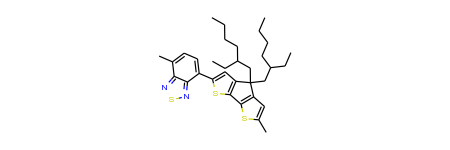

In [793]:
# smi_can = 'CCCCC(CC)CC1(CC(CC)CCCC)c2cc(C)sc2-c2sc(-c3ccc(C)c4nsnc34)cc21'
smi = 'CC1=CC(C(CC(CCCC)CC)(CC(CCCC)CC)C2=C3SC(C4=CC=C(C)C5=NSN=C45)=C2)=C3S1'
mol = Chem.MolFromSmiles(smi)
# mol_can = Chem.MolFromSmiles(smi_can)
mol
# mol_can

In [11]:
# P3HT monomer
P3HT = 'CCCCCCc1cc(C)sc1C'
PSEHTT = 'CC1=CC(CC(CC)CCCC)=C(C2=NC(SC(C3=C(CC(CCCC)CC)C=C(C4=CC([Si](CC(CC)CCCC)(CC(CCCC)CC)C5=C6SC(C)=C5)=C6S4)S3)=N7)=C7S2)S1'
PCBTDPP = 'O=C1N(CCCCCCCC)C(C2=CC=C(C)S2)=C3C1=C(C4=CC=C(C(C=C5)=CC6=C5C7=CC=C(C)C=C7N6C(CCCCCCCC)CCCCCCCC)S4)N(CCCCCCCC)C3=O'

The following is try to split the SMILES and sum up the mass of backbone and side chains

In [12]:
SMILES3 = 'CCCCCCCCCCCCCCc1cc(C)sc1-c1cc2sc(-c3sc(C)cc3CCCCCCCCCCCCCC)cc2s1'
mol3 = Chem.MolFromSmiles(SMILES3)

# #6 searches for all carbons, since the atomic number is 6
mat3 = Chem.MolFromSmarts("[]")
num3 = len(mol3.GetSubstructMatches(mat3))

# rdkit.Chem.Descriptors.HeavyAtomMolWt(x)
# mol3.GetNumBonds()
# mol3.GetNumHeavyAtoms()
num3

ArgumentError: Python argument types in
    Mol.GetSubstructMatches(Mol, NoneType)
did not match C++ signature:
    GetSubstructMatches(class RDKit::ROMol self, class RDKit::MolBundle query, bool uniquify=True, bool useChirality=False, bool useQueryQueryMatches=False, unsigned int maxMatches=1000)
    GetSubstructMatches(class RDKit::ROMol self, class RDKit::ROMol query, bool uniquify=True, bool useChirality=False, bool useQueryQueryMatches=False, unsigned int maxMatches=1000)

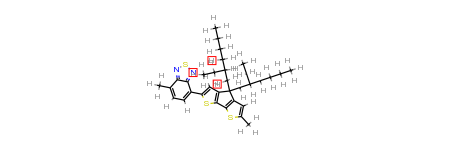

In [797]:
# 'CCCCCCCCCCCCCCc1cc(C)sc1-c1cc2sc(-c3sc(C)cc3CCCCCCCCCCCCCC)cc2s1'
mol3 = Chem.AddHs(mol)
mol3
# why are some of them in red?

from the above cases, we can see it is possible to extract side chains and backbone carbons, but hard to calculate the mass.

For the hydrocarbon side chain, we can calculate its mass by using the equation: 

In [34]:
MW = df['Monomer (g mol^-1)']
mass_S = [32.065 * x for x in df.S]
mass_N = [14.0067 * x for x in df.N]
mass_O = [15.999 * x for x in df.O]
mass_F = [18.998403 * x for x in df.F]
mass_H = [1.00794 * x for x in df.H]
mass_Ge = [72.63 * x for x in df.Ge]
mass_Si = [28.085 * x for x in df.Si]

exact_W = MW - mass_S - mass_N - mass_O - mass_F - mass_H - mass_Ge - mass_Si
exact_W 
# in this case, the remaining can be assumed to be all carbons

ID No.
1        561.470040
2        561.538760
3        417.616920
4        814.283674
5        814.283674
6        814.283674
7        814.283674
8        862.186200
9        533.530217
10       405.531920
11       966.122680
12       687.209880
13       966.254680
14       154.863540
15       533.485920
16       533.485920
17       642.359517
18       642.359517
19       642.359517
20       642.359517
21       546.523277
22       686.460120
23       686.469657
24       686.479194
25       484.739220
26       372.819620
27       444.722860
28       703.530820
29       798.369060
30       794.321940
31       561.538760
32       561.604760
33       573.589120
34       549.540000
35       585.587880
36       549.606000
37       537.607240
38       561.590360
39       772.479200
40       613.507000
41       641.507000
42       757.443480
43       561.553400
44       589.553400
45       705.489880
46       960.317680
47       988.317680
48      1104.254160
49      1038.306280
50       662.

In [19]:
def countChain(mol):
    mat = Chem.MolFromSmarts("C") # all aromatic carbon atom - chain 
    num = len(mol.GetSubstructMatches(mat))
    return num * 12.0107

In [45]:
chain_Wt = []
MW = df['Monomer (g mol^-1)']

for smi in df.SMILES:
    mol = Chem.MolFromSmiles(smi)
    chain_Wt.append(countChain(mol))

df['side chain'] = chain_Wt
df['backbone'] = MW - chain_Wt
df['backbone / side chain (%)'] = (df['backbone'] / df['side chain'])*100
df['side chain / backbone (%)'] = (1/df['backbone / side chain'])*100
df['backbone_ratio (%)'] = (df['backbone']  / MW)*100
df['chain_ratio (%)'] = (df['side chain']  / MW)*100

df = df.drop(columns=["backbone_ratio","chain_ratio","backbone / side chain", "side chain / backbone"])

In [46]:
df.head(5)

,Nickname,Ref. No,PCE_max(%),PCE_ave(%),Voc (V),Jsc (mA cm^2),FF,Mw (kg mol^-1),Mn (kg mol^-1),PDI (=Mw/Mn),...,Ge,C,H,category,backbone,side chain,backbone / side chain (%),side chain / backbone (%),backbone_ratio (%),chain_ratio (%)
ID No.,,,,,,,,,,,,,,,,,,,,,
1,PBTTT-C14,S1,2.34,2.34,0.53,9.37,0.48,46.2,22.0,2.10,...,0,44,34,NaN,363.6790,360.3210,100.931947,99.076658,50.231906,49.768094
2,PCDTBT,S2,3.60,3.60,0.89,6.92,0.63,73.0,37.0,1.97,...,0,45,31,NaN,502.7967,228.2033,220.328409,45.386794,68.782038,31.217962
3,PCPDTBT,S3,5.12,5.12,0.61,15.73,0.53,47.6,26.6,1.79,...,0,33,22,NaN,335.7967,228.2033,147.148047,67.958768,59.538422,40.461578
4,PffBT4T-2OD,S4,10.50,10.20,0.77,18.40,0.74,93.7,47.5,1.97,...,0,64,48,NaN,584.5506,504.4494,115.878937,86.296960,53.677741,46.322259
5,PffBT4T-2OD,S4,10.40,10.00,0.77,18.20,0.74,52.9,28.2,1.88,...,0,64,48,NaN,584.5506,504.4494,115.878937,86.296960,53.677741,46.322259


In [47]:
df.to_csv("./data/compdata_classification.csv")

In [48]:
df.columns

Index(['Nickname', 'Ref. No', 'PCE_max(%)', 'PCE_ave(%)', 'Voc (V)', 'Jsc (mA cm^2)', 'FF', 'Mw (kg mol^-1)', 'Mn (kg mol^-1)', 'PDI (=Mw/Mn)', 'Monomer (g mol^-1)', '-HOMO (eV)', '-LUMO (eV)', 'bandgap(eV)', 'SMILES', 'canonical_SMILES', 'formula', 'S', 'N', 'O', 'F', 'Si', 'Ge', 'C', 'H', 'category', 'backbone', 'side chain', 'backbone / side chain (%)', 'side chain / backbone (%)', 'backbone_ratio (%)', 'chain_ratio (%)'], dtype='object')

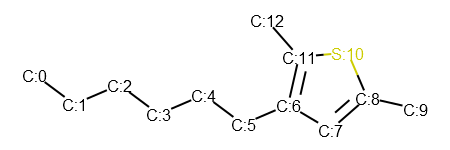

In [23]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_useSVG = True
 
def mol_with_atom_index(mol):
    atoms = mol.GetNumAtoms()
    for idx in range(atoms):
        mol.GetAtomWithIdx(idx).SetProp('molAtomMapNumber', str(mol.GetAtomWithIdx(idx).GetIdx()))
    return mol

mol = Chem.MolFromSmiles(P3HT)
#Default
#image = Draw.MolsToImage(mol,subImgSize=(200,200))
mol
#With index
s = mol_with_atom_index(mol)
s

In [11]:
P = "CC1=C2N=C(C3=CC(C(C(F)=CC(F)=C4)=C4C5(CCCCCCCCCCCC)CCCCCCCCCCCC)=C5C=C3)C(C6=CC=C(C(CCCCCCCCCCCC)(CCCCCCCCCCCC)C7=C8C(F)=CC(F)=C7)C8=C6)=NC2=C(C9=CC=C(C%10=CC=C(C%11=CC=C(C)S%11)C%12=NSN=C%10%12)S9)C%13=NSN=C1%13"
P1 = "CC1=CC2=C(C(OCCCCCCCCCCCC)=C(C=C(C3=C(CCCCCCCCCCCC)C=C(C4=C5C(N=C(C(N=C(C(CC)CCCCCCCCCCCCCCCC)S6)=C6C7=C8N=C(C(CC)CCCCCCCCCCCCCCCC)S7)C8=N5)=C(C9=CC(CCCCCCCCCCCC)=C(C)S9)C%10=NSN=C4%10)S3)S%11)C%11=C2OCCCCCCCCCCCC)S1"
P2 = "CC1=C(CCCCCCCCCCCC)C=C(S1)C2=C(N=C(C(N=C(C(CC)CCCCCCCCCCCCCCCC)S3)=C3C4=C5N=C(C(CC)CCCCCCCCCCCCCCCC)S4)C5=N6)C6=C(C7=NSN=C72)C8=CC(CCCCCCCCCCCC)=C(S8)C9=CC%10=C(C(SC(C)=C%11)=C%11[Si]%10(CCCCCCCC)CCCCCCCC)S9"
PIDTTPIT = "CC1=C(C(N(CC(CC)CCCC)C2=O)=O)C2=C(C3=NSN=C31)C4=CC(S5)=C(S4)C6=C5C7=C(C6(C8=CC=CC(CCCCCC)=C8)C9=CC(CCCCCC)=CC=C9)C=C%10C%11=C(C(SC(C)=C%12)=C%12S%11)C(C%13=CC(CCCCCC)=CC=C%13)(C%14=CC=CC(CCCCCC)=C%14)C%10=C7"
last_four = [P, P1, P2, PIDTTPIT]
Name = ['P','P1','P2','PIDTT-PIT']
mol1 = Chem.MolFromSmiles(P)
mol2 = Chem.MolFromSmiles(P1)
mol3 = Chem.MolFromSmiles(P2)
mol4 = Chem.MolFromSmiles(PIDTTPIT)

STREAM b'IHDR' 16 13
STREAM b'bKGD' 41 6
b'bKGD' 41 6 (unknown)
STREAM b'IDAT' 59 8192


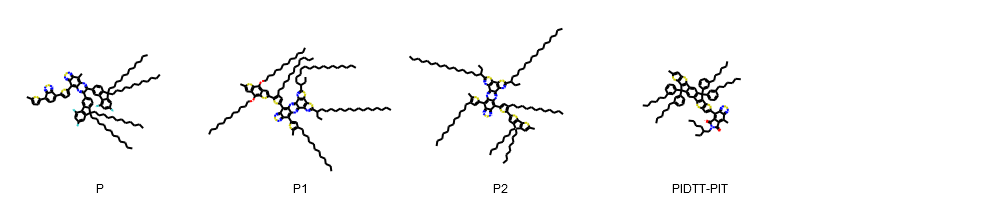

In [13]:
mol = [Chem.MolFromSmiles(x) for x in last_four]
s = Draw.MolsToGridImage(mol,molsPerRow=5,legends=[x for x in Name],subImgSize=(200,200))
s.save(fp="Images/moles/last_four",format="PNG")
s